# Credit Card Fraud Detection Using Machine Learning

### Learning Objectives
1. Understand imbalanced datasets and their challenges
2. Apply different sampling techniques (oversampling, undersampling, SMOTE)
3. Compare multiple ML algorithms for fraud detection
4. Evaluate models using appropriate metrics
5. Understand the business context of fraud detection

### Dataset Information
Download the dataset from: https://www.kaggle.com/mlg-ulb/creditcardfraud

The dataset contains:
- **284,807 transactions** made by European cardholders in September 2013
- **492 frauds** out of 284,807 transactions (0.172% of all transactions)
- **Features V1-V28**: Principal components obtained with PCA
- **Time**: Seconds elapsed between transactions
- **Amount**: Transaction amount
- **Class**: 1 for fraud, 0 for normal

## Part 1: Setup and Imports
Let's start by importing all necessary libraries.

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

All libraries imported successfully!
NumPy version: 2.0.2
Pandas version: 2.2.2
Scikit-learn version: 1.6.1


## Part 2: Understanding the Problem
Before we dive into the code, let's understand why credit card fraud detection is challenging.

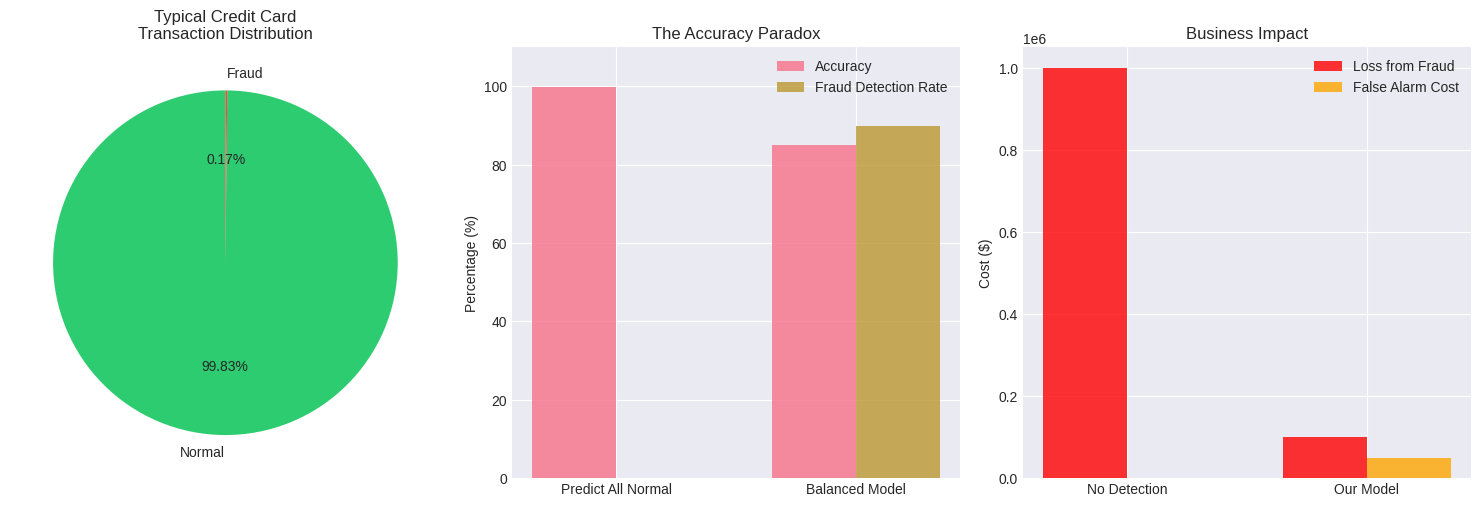

Key Insights:
1. Fraud is rare (0.17%), making it hard to detect
2. A model that predicts everything as 'normal' gets 99.83% accuracy!
3. But this model catches 0% of fraud - terrible for business!
4. We need to balance between catching fraud and avoiding false alarms


In [ ]:
# Visualize the imbalanced data problem
def visualize_imbalance_concept():
    """
    This function helps students understand why imbalanced datasets are problematic.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 1. Typical distribution
    ax = axes[0]
    sizes = [99.83, 0.17]
    colors = ['#2ecc71', '#e74c3c']
    ax.pie(sizes, labels=['Normal', 'Fraud'], colors=colors, autopct='%1.2f%%', startangle=90)
    ax.set_title('Typical Credit Card\nTransaction Distribution')

    # 2. The accuracy paradox
    ax = axes[1]
    models = ['Predict All Normal', 'Balanced Model']
    accuracy = [99.83, 85]
    fraud_detection = [0, 90]

    x = np.arange(len(models))
    width = 0.35

    ax.bar(x - width/2, accuracy, width, label='Accuracy', alpha=0.8)
    ax.bar(x + width/2, fraud_detection, width, label='Fraud Detection Rate', alpha=0.8)
    ax.set_ylabel('Percentage (%)')
    ax.set_title('The Accuracy Paradox')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.set_ylim(0, 110)

    # 3. Business impact
    ax = axes[2]
    impact_data = {
        'Scenario': ['No Detection', 'Our Model'],
        'Loss from Fraud': [1000000, 100000],
        'False Alarm Cost': [0, 50000]
    }
    df_impact = pd.DataFrame(impact_data)

    x = np.arange(len(df_impact))
    ax.bar(x - width/2, df_impact['Loss from Fraud'], width, label='Loss from Fraud', color='red', alpha=0.8)
    ax.bar(x + width/2, df_impact['False Alarm Cost'], width, label='False Alarm Cost', color='orange', alpha=0.8)
    ax.set_ylabel('Cost ($)')
    ax.set_title('Business Impact')
    ax.set_xticks(x)
    ax.set_xticklabels(df_impact['Scenario'])
    ax.legend()

    plt.tight_layout()
    plt.show()

    print("Key Insights:")
    print("1. Fraud is rare (0.17%), making it hard to detect")
    print("2. A model that predicts everything as 'normal' gets 99.83% accuracy!")
    print("3. But this model catches 0% of fraud - terrible for business!")
    print("4. We need to balance between catching fraud and avoiding false alarms")

visualize_imbalance_concept()

## Part 3: Load and Explore the Dataset
Now let's load the actual credit card dataset and explore its characteristics.

In [ ]:
# Load the dataset
# Make sure to upload the creditcard.csv file first!
try:
    dataset = pd.read_csv('creditcard.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: creditcard.csv not found!")

Dataset loaded successfully!


In [ ]:
# Explore the dataset
print("\nDATASET OVERVIEW")
print("=" * 100)
print(f"Shape: {dataset.shape}")
print(f"Columns: {list(dataset.columns[:5])} ... {list(dataset.columns[-3:])}")
print(f"\nMemory usage: {dataset.memory_usage().sum() / 1024**2:.2f} MB")
print(f"\nMissing values: {dataset.isnull().sum().sum()}")

# Class distribution
fraud_count = dataset['Class'].sum()
normal_count = len(dataset) - fraud_count

print(f"\n\nCLASS DISTRIBUTION")
print("=" * 100)
print(f"Normal transactions: {normal_count:,} ({normal_count/len(dataset)*100:.2f}%)")
print(f"Fraud transactions: {fraud_count:,} ({fraud_count/len(dataset)*100:.2f}%)")
print(f"Imbalance ratio: 1:{int(normal_count/fraud_count)}")

# Display sample data
print("\n\nSAMPLE DATA (First 5 rows)")
print("=" * 100)
display(dataset.head())


DATASET OVERVIEW
Shape: (284807, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4'] ... ['V28', 'Amount', 'Class']

Memory usage: 67.36 MB

Missing values: 0


CLASS DISTRIBUTION
Normal transactions: 284,315 (99.83%)
Fraud transactions: 492 (0.17%)
Imbalance ratio: 1:577


SAMPLE DATA (First 5 rows)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


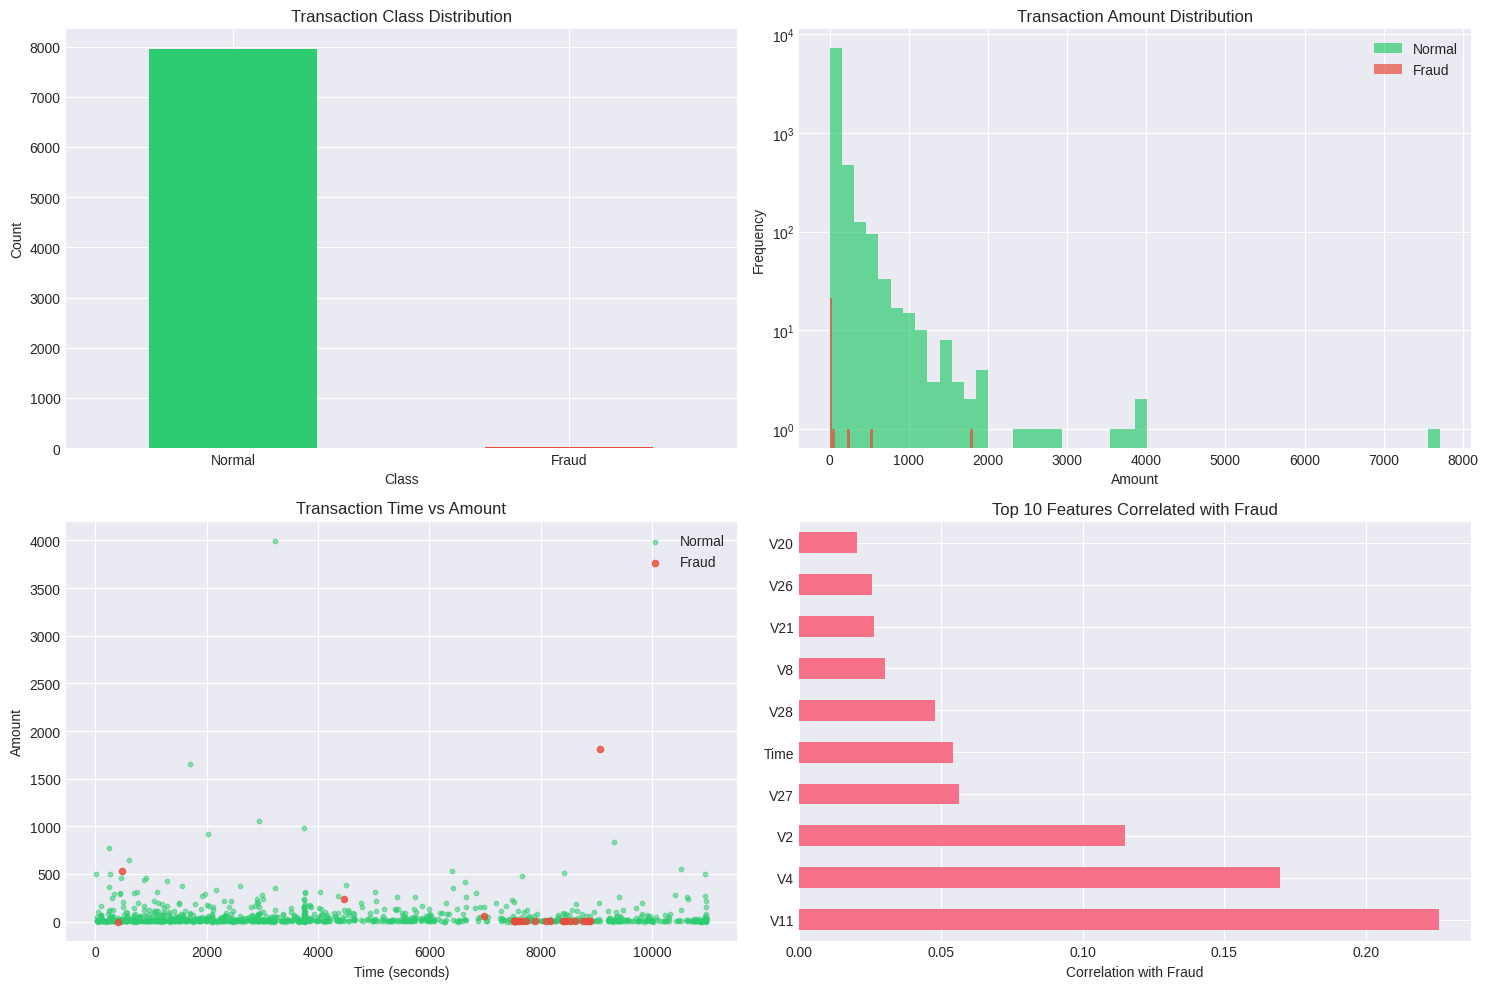

In [ ]:
# Visualize data characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Class distribution
ax = axes[0, 0]
dataset['Class'].value_counts().plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'])
ax.set_title('Transaction Class Distribution')
ax.set_xticklabels(['Normal', 'Fraud'], rotation=0)
ax.set_ylabel('Count')

# 2. Transaction amounts
ax = axes[0, 1]
dataset[dataset['Class'] == 0]['Amount'].hist(bins=50, alpha=0.7, label='Normal', ax=ax, color='#2ecc71')
dataset[dataset['Class'] == 1]['Amount'].hist(bins=50, alpha=0.7, label='Fraud', ax=ax, color='#e74c3c')
ax.set_xlabel('Amount')
ax.set_ylabel('Frequency')
ax.set_title('Transaction Amount Distribution')
ax.legend()
ax.set_yscale('log')

# 3. Time distribution
ax = axes[1, 0]
sample_size = min(1000, len(dataset[dataset['Class'] == 0]))
ax.scatter(dataset[dataset['Class'] == 0]['Time'].sample(sample_size),
           dataset[dataset['Class'] == 0]['Amount'].sample(sample_size),
           alpha=0.5, label='Normal', s=10, c='#2ecc71')
ax.scatter(dataset[dataset['Class'] == 1]['Time'],
           dataset[dataset['Class'] == 1]['Amount'],
           alpha=0.8, label='Fraud', s=20, c='#e74c3c')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Amount')
ax.set_title('Transaction Time vs Amount')
ax.legend()

# 4. Feature correlation with fraud
ax = axes[1, 1]
correlations = dataset.corr()['Class'].drop('Class').sort_values(ascending=False)
top_correlations = correlations.head(10)
top_correlations.plot(kind='barh', ax=ax)
ax.set_xlabel('Correlation with Fraud')
ax.set_title('Top 10 Features Correlated with Fraud')

plt.tight_layout()
plt.show()

## Part 4: Data Preparation
Let's prepare our data for machine learning. We'll start with a simplified version using only 2 features for easier understanding.

In [ ]:
# Prepare features and target
# For educational purposes, we'll start with just 2 features
print("\nPREPARING DATA FOR MODELING")
print("=" * 100)

# Drop rows with missing values
dataset_cleaned = dataset.dropna()

# Option 1: Simple approach with 2 features (easier to visualize)
X_simple = dataset_cleaned[['Time', 'Amount']].values
y = dataset_cleaned['Class'].values

# Option 2: Full approach with all features (better performance)
# Uncomment the lines below to use all features
# feature_cols = [col for col in dataset_cleaned.columns if col not in ['Class']]
# X_full = dataset_cleaned[feature_cols].values

print(f"Using simple approach with 2 features: Time and Amount")
print(f"Feature matrix shape: {X_simple.shape}")
print(f"Target vector shape: {y.shape}")

# Split the data
# stratify=y <- this ensures class balance is preserved
X_train, X_test, y_train, y_test = train_test_split(
    X_simple, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n\nTRAIN-TEST SPLIT")
print("=" * 100)
print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")
print(f"\nFraud cases in training: {sum(y_train):,} ({sum(y_train)/len(y_train)*100:.2f}%)")
print(f"Fraud cases in test: {sum(y_test):,} ({sum(y_test)/len(y_test)*100:.2f}%)")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print()
print("=" * 100)
print("Data preparation completed!")


PREPARING DATA FOR MODELING
Using simple approach with 2 features: Time and Amount
Feature matrix shape: (284807, 2)
Target vector shape: (284807,)


TRAIN-TEST SPLIT
Training set: 199,364 samples
Test set: 85,443 samples

Fraud cases in training: 344 (0.17%)
Fraud cases in test: 148 (0.17%)

Data preparation completed!


## Part 5: Baseline Model (No Balancing)
Let's first train a model without handling the imbalance to see what happens.

In [ ]:
# Train baseline model
print("\nTRAINING BASELINE MODEL (No Balancing)")
print("=" * 100)

# Train logistic regression
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_baseline = baseline_model.predict(X_test_scaled)
y_proba_baseline = baseline_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
tn, fp, fn, tp = cm_baseline.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Display results
print("\n\nCONFUSION MATRIX:")
print("                 Predicted Predicted")
print("                  Normal     Fraud")
print(f"Actual Normal    {tn:6d}    {fp:5d}")
print(f"Actual Fraud     {fn:6d}    {tp:5d}")

print(f"\n\nMETRICS:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f} (This is our fraud detection rate!)")
print(f"F1-Score:  {f1:.3f}")

print(f"\n\nWARNING: We're only catching {recall*100:.1f}% of fraud cases!")
print(f"This means we're missing {(1-recall)*100:.1f}% of fraudulent transactions!")


TRAINING BASELINE MODEL (No Balancing)


CONFUSION MATRIX:
                 Predicted Predicted
                  Normal     Fraud
Actual Normal     85295        0
Actual Fraud        148        0


METRICS:
Accuracy:  0.998
Precision: 0.000
Recall:    0.000 (This is our fraud detection rate!)
F1-Score:  0.000


This means we're missing 100.0% of fraudulent transactions!


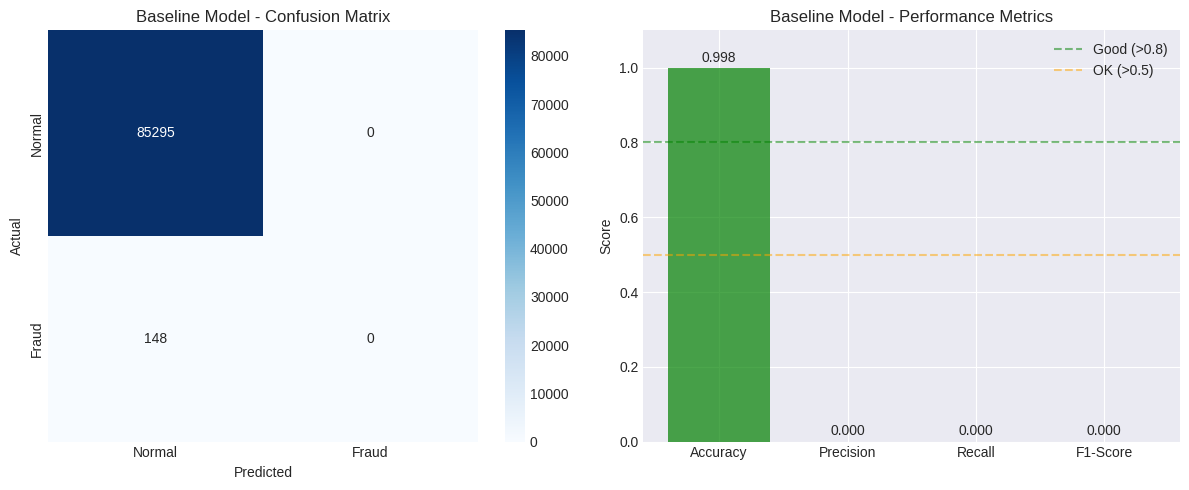

In [ ]:
# Visualize the baseline model's performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix heatmap
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_xticklabels(['Normal', 'Fraud'])
ax1.set_yticklabels(['Normal', 'Fraud'])
ax1.set_title('Baseline Model - Confusion Matrix')

# Metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
colors = ['green' if v > 0.8 else 'orange' if v > 0.5 else 'red' for v in values]

bars = ax2.bar(metrics, values, color=colors, alpha=0.7)
ax2.set_ylim(0, 1.1)
ax2.set_ylabel('Score')
ax2.set_title('Baseline Model - Performance Metrics')
ax2.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Good (>0.8)')
ax2.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='OK (>0.5)')

# Add value labels on bars
for bar, value in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

ax2.legend()
plt.tight_layout()
plt.show()

## Part 6: Handling Imbalanced Data
Now let's implement different techniques to handle the imbalanced dataset.

In [ ]:
# Define sampling functions
def apply_random_oversampling(X_train, y_train):
    """
    Random Oversampling: Duplicate minority class samples randomly.
    """
    print("Applying Random Oversampling...")

    # Separate classes
    X_majority = X_train[y_train == 0]
    X_minority = X_train[y_train == 1]
    y_majority = y_train[y_train == 0]
    y_minority = y_train[y_train == 1]

    print(f"Before: {len(y_majority)} normal, {len(y_minority)} fraud")

    # Oversample minority class
    X_minority_upsampled, y_minority_upsampled = resample(
        X_minority, y_minority,
        n_samples=len(y_majority),
        random_state=42
    )

    # Combine
    X_balanced = np.vstack([X_majority, X_minority_upsampled])
    y_balanced = np.hstack([y_majority, y_minority_upsampled])

    print(f"After: {sum(y_balanced==0)} normal, {sum(y_balanced==1)} fraud")

    return X_balanced, y_balanced


def apply_random_undersampling(X_train, y_train):
    """
    Random Undersampling: Remove majority class samples randomly.
    """
    print("Applying Random Undersampling...")

    # Separate classes
    X_majority = X_train[y_train == 0]
    X_minority = X_train[y_train == 1]
    y_majority = y_train[y_train == 0]
    y_minority = y_train[y_train == 1]

    print(f"Before: {len(y_majority)} normal, {len(y_minority)} fraud")

    # Undersample majority class
    X_majority_downsampled, y_majority_downsampled = resample(
        X_majority, y_majority,
        n_samples=len(y_minority),
        random_state=42
    )

    # Combine
    X_balanced = np.vstack([X_majority_downsampled, X_minority])
    y_balanced = np.hstack([y_majority_downsampled, y_minority])

    print(f"After: {sum(y_balanced==0)} normal, {sum(y_balanced==1)} fraud")

    return X_balanced, y_balanced


def apply_smote(X_train, y_train):
    """
    SMOTE: Create synthetic minority class samples.
    """
    try:
        from imblearn.over_sampling import SMOTE
        print("Applying SMOTE...")

        print(f"Before: {sum(y_train==0)} normal, {sum(y_train==1)} fraud")

        smote = SMOTE(random_state=42)
        X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

        print(f"After: {sum(y_balanced==0)} normal, {sum(y_balanced==1)} fraud")
        print("SMOTE creates synthetic fraud examples using k-nearest neighbors!")

        return X_balanced, y_balanced

    except ImportError:
        print("imbalanced-learn not installed. Install with: pip install imbalanced-learn")
        print("Using random oversampling instead...")
        return apply_random_oversampling(X_train, y_train)

In [ ]:
# Apply different sampling techniques
print("APPLYING DIFFERENT SAMPLING TECHNIQUES")
print("=" * 100)

# 1. Random Oversampling
#    Duplicates random examples from the minority class to balance the class distribution.
print("\n1. RANDOM OVERSAMPLING")
print("-" * 100)
X_train_over, y_train_over = apply_random_oversampling(X_train_scaled, y_train)

# 2. Random Undersampling
#    Removes random examples from the majority class to match the size of the minority class.
print("\n2. RANDOM UNDERSAMPLING")
print("-" * 100)
X_train_under, y_train_under = apply_random_undersampling(X_train_scaled, y_train)

# 3. SMOTE
#    Creates synthetic examples of the minority class by interpolating between neighbors.
print("\n3. SMOTE (Synthetic Minority Over-sampling Technique)")
print("-" * 100)
X_train_smote, y_train_smote = apply_smote(X_train_scaled, y_train)

APPLYING DIFFERENT SAMPLING TECHNIQUES

1. RANDOM OVERSAMPLING
----------------------------------------------------------------------------------------------------
Applying Random Oversampling...
Before: 199020 normal, 344 fraud
After: 199020 normal, 199020 fraud

2. RANDOM UNDERSAMPLING
----------------------------------------------------------------------------------------------------
Applying Random Undersampling...
Before: 199020 normal, 344 fraud
After: 344 normal, 344 fraud

3. SMOTE (Synthetic Minority Over-sampling Technique)
----------------------------------------------------------------------------------------------------
Applying SMOTE...
Before: 199020 normal, 344 fraud
After: 199020 normal, 199020 fraud
SMOTE creates synthetic fraud examples using k-nearest neighbors!


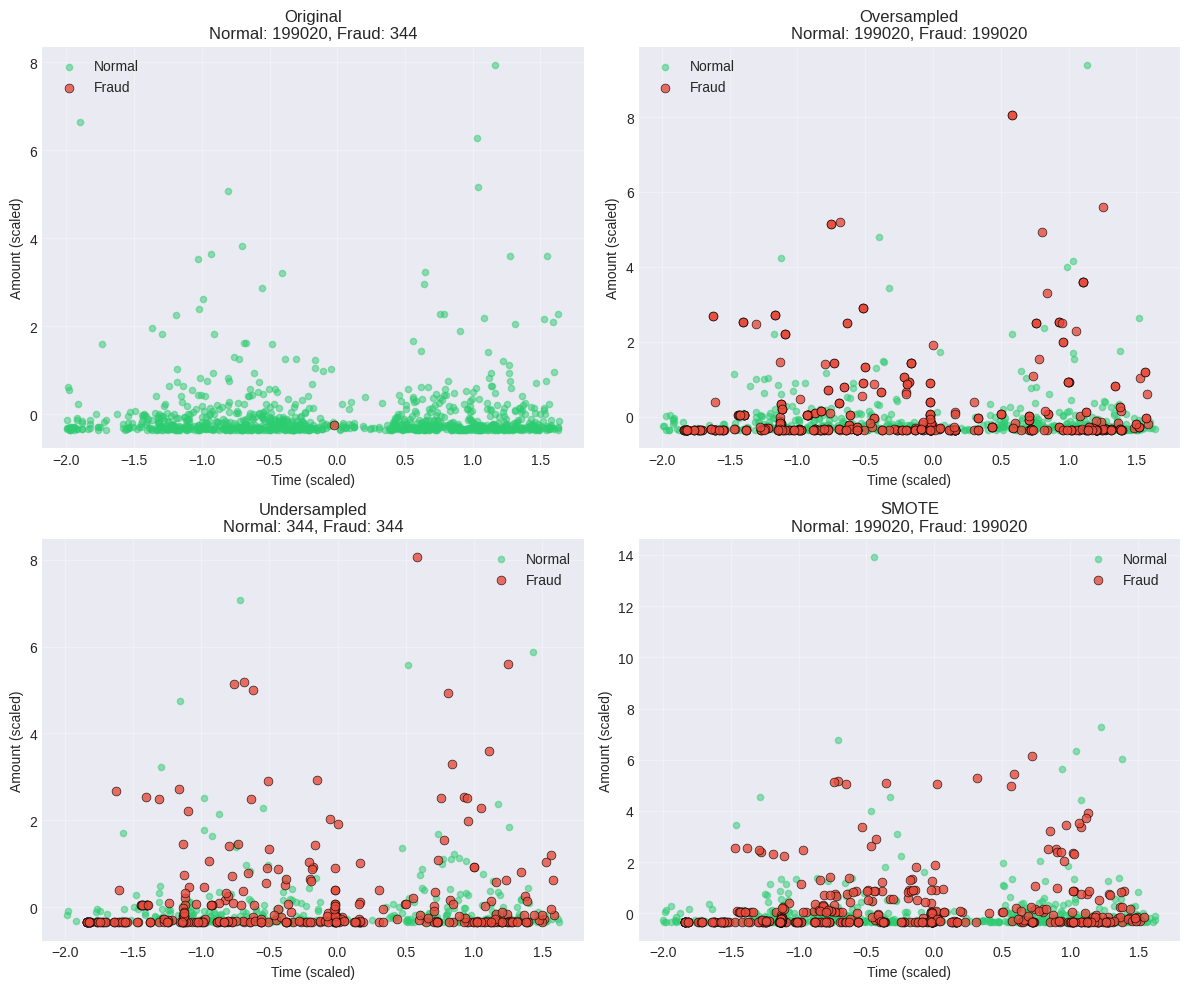

In [ ]:
# Visualize the effect of different sampling techniques
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

datasets = [
    ('Original', X_train_scaled, y_train),
    ('Oversampled', X_train_over, y_train_over),
    ('Undersampled', X_train_under, y_train_under),
    ('SMOTE', X_train_smote, y_train_smote)
]

for idx, (title, X, y) in enumerate(datasets):
    ax = axes[idx // 2, idx % 2]

    # Plot scatter (limit points for visualization)
    n_plot = min(1000, len(X))
    indices = np.random.choice(len(X), n_plot, replace=False)

    # Plot normal class
    normal_idx = np.where(y[indices] == 0)[0]
    ax.scatter(X[indices][normal_idx, 0], X[indices][normal_idx, 1],
               c='#2ecc71', alpha=0.5, s=20, label='Normal')

    # Plot fraud class
    fraud_idx = np.where(y[indices] == 1)[0]
    ax.scatter(X[indices][fraud_idx, 0], X[indices][fraud_idx, 1],
               c='#e74c3c', alpha=0.8, s=40, label='Fraud', edgecolors='black', linewidth=0.5)

    ax.set_title(f'{title}\nNormal: {sum(y==0)}, Fraud: {sum(y==1)}')
    ax.set_xlabel('Time (scaled)')
    ax.set_ylabel('Amount (scaled)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 7: Compare Different Models and Techniques
Let's train multiple models with different sampling techniques and compare their performance.

In [ ]:
# Define function to train and evaluate models
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name, sampling_name):
    """
    Train a model and evaluate its performance.
    """
    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    auc = roc_auc_score(y_test, y_proba)

    return {
        'Model': model_name,
        'Sampling': sampling_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn
    }

In [ ]:
# Train multiple models with different techniques
print("TRAINING MULTIPLE MODELS")
print("=" * 100)

# Define models to test
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Define sampling techniques
sampling_techniques = {
    'No Sampling': (X_train_scaled, y_train),
    'Oversampling': (X_train_over, y_train_over),
    'Undersampling': (X_train_under, y_train_under),
    'SMOTE': (X_train_smote, y_train_smote)
}

# Store results
results = []

# Train and evaluate each combination
for sampling_name, (X_train_sampled, y_train_sampled) in sampling_techniques.items():
    print(f"\n{sampling_name}:")
    for model_name, model in models.items():
        print(f"  Training {model_name}...", end='')
        result = train_and_evaluate(
            model.clone() if hasattr(model, 'clone') else type(model)(**model.get_params()),
            X_train_sampled, y_train_sampled,
            X_test_scaled, y_test,
            model_name, sampling_name
        )
        results.append(result)
        print(f" ✓ (Recall: {result['Recall']:.3f})")

print("\nAll models trained successfully!")

TRAINING MULTIPLE MODELS

No Sampling:
  Training Logistic Regression... ✓ (Recall: 0.000)
  Training Random Forest... ✓ (Recall: 0.142)
  Training Decision Tree... ✓ (Recall: 0.027)
  Training KNN... ✓ (Recall: 0.034)

Oversampling:
  Training Logistic Regression... ✓ (Recall: 0.628)
  Training Random Forest... ✓ (Recall: 0.155)
  Training Decision Tree... ✓ (Recall: 0.628)
  Training KNN... ✓ (Recall: 0.182)

Undersampling:
  Training Logistic Regression... ✓ (Recall: 0.615)
  Training Random Forest... ✓ (Recall: 0.676)
  Training Decision Tree... ✓ (Recall: 0.682)
  Training KNN... ✓ (Recall: 0.669)

SMOTE:
  Training Logistic Regression... ✓ (Recall: 0.628)
  Training Random Forest... ✓ (Recall: 0.331)
  Training Decision Tree... ✓ (Recall: 0.696)
  Training KNN... ✓ (Recall: 0.405)

All models trained successfully!


In [ ]:
# Create comprehensive results comparison
results_df = pd.DataFrame(results)

print("COMPREHENSIVE RESULTS COMPARISON")
print("=" * 100)

# Sort by recall (most important for fraud detection)
results_df_sorted = results_df.sort_values('Recall', ascending=False)

# Display key metrics
display_columns = ['Model', 'Sampling', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
print(results_df_sorted[display_columns].to_string(index=False))

print("\nKEY INSIGHTS:")
best_recall = results_df_sorted.iloc[0]
best_f1 = results_df.loc[results_df['F1-Score'].idxmax()]
best_precision = results_df.loc[results_df['Precision'].idxmax()]

print(f"\nBest Fraud Detection (Recall): {best_recall['Model']} with {best_recall['Sampling']}")
print(f"   - Catches {best_recall['Recall']*100:.1f}% of fraud cases")
print(f"   - {best_recall['TP']} frauds caught, {best_recall['FN']} frauds missed")

print(f"\nBest Overall Balance (F1): {best_f1['Model']} with {best_f1['Sampling']}")
print(f"   - F1-Score: {best_f1['F1-Score']:.3f}")

print(f"\nFewest False Alarms (Precision): {best_precision['Model']} with {best_precision['Sampling']}")
print(f"   - {best_precision['FP']} false alarms out of {best_precision['TP'] + best_precision['FP']} fraud predictions")

COMPREHENSIVE RESULTS COMPARISON
              Model      Sampling  Accuracy  Precision   Recall  F1-Score      AUC
      Decision Tree         SMOTE  0.655291   0.003490 0.695946  0.006946 0.715113
      Decision Tree Undersampling  0.719076   0.004198 0.682432  0.008345 0.728063
      Random Forest Undersampling  0.747715   0.004628 0.675676  0.009193 0.766124
                KNN Undersampling  0.648362   0.003290 0.668919  0.006547 0.697258
      Decision Tree  Oversampling  0.781574   0.004973 0.628378  0.009868 0.734711
Logistic Regression  Oversampling  0.511546   0.002226 0.628378  0.004437 0.610188
Logistic Regression         SMOTE  0.503681   0.002191 0.628378  0.004367 0.607713
Logistic Regression Undersampling  0.533689   0.002282 0.614865  0.004547 0.611990
                KNN         SMOTE  0.891577   0.006496 0.405405  0.012788 0.670397
      Random Forest         SMOTE  0.944396   0.010423 0.331081  0.020210 0.713705
                KNN  Oversampling  0.993984   0.064286

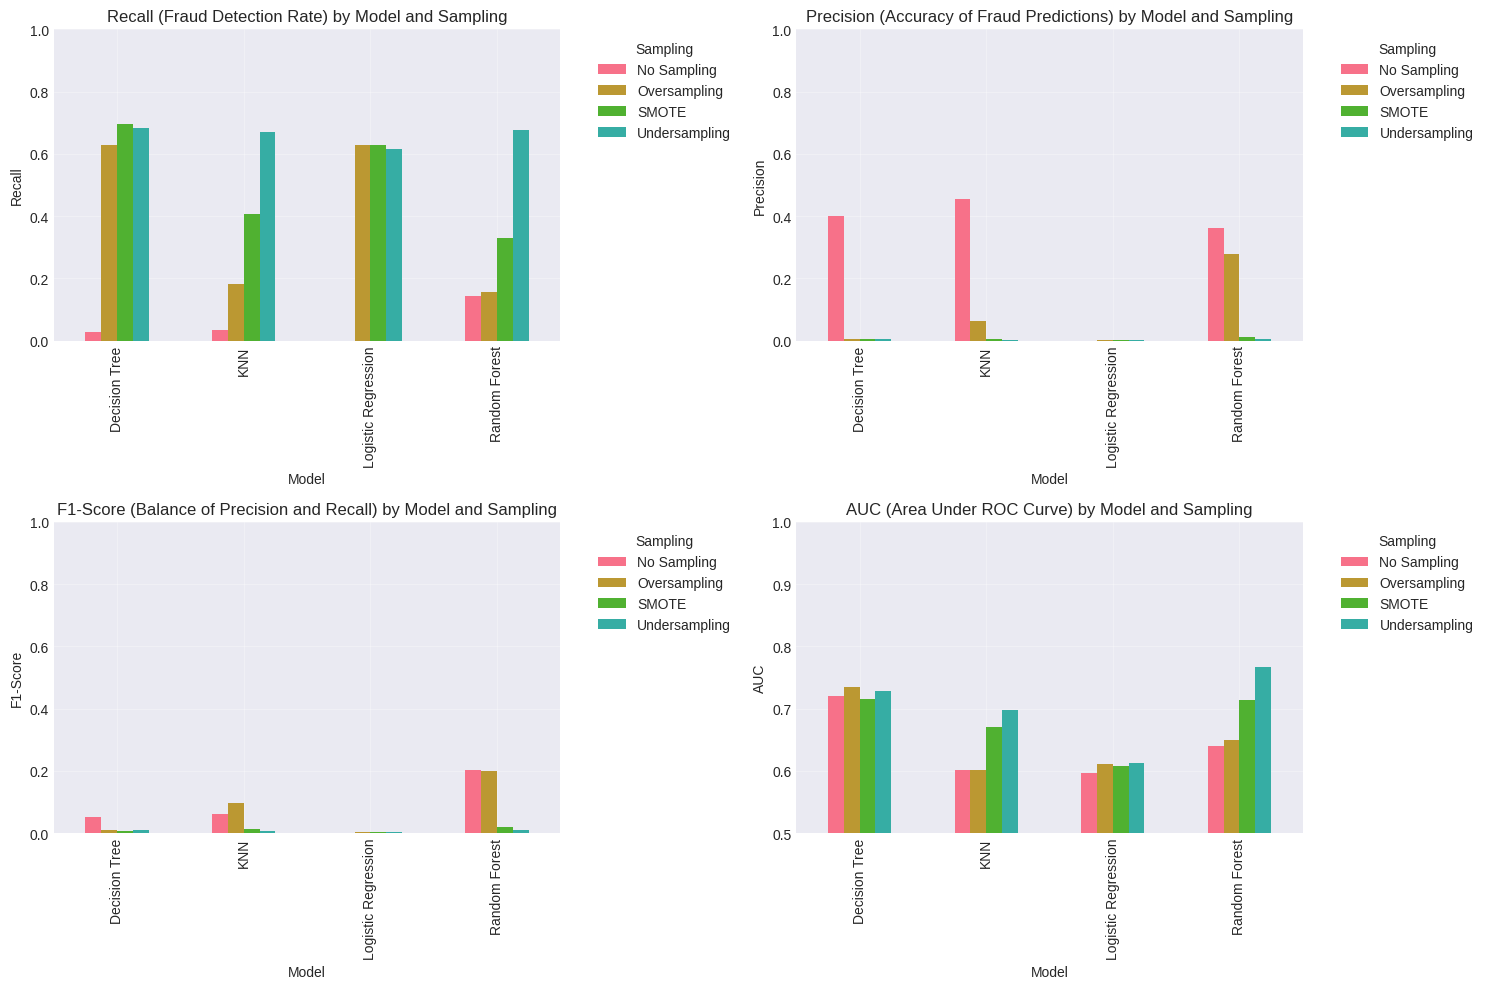

In [ ]:
# Visualize results comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Recall comparison (most important for fraud)
ax = axes[0, 0]
pivot_recall = results_df.pivot(index='Model', columns='Sampling', values='Recall')
pivot_recall.plot(kind='bar', ax=ax)
ax.set_title('Recall (Fraud Detection Rate) by Model and Sampling')
ax.set_ylabel('Recall')
ax.set_ylim(0, 1)
ax.legend(title='Sampling', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# 2. Precision comparison
ax = axes[0, 1]
pivot_precision = results_df.pivot(index='Model', columns='Sampling', values='Precision')
pivot_precision.plot(kind='bar', ax=ax)
ax.set_title('Precision (Accuracy of Fraud Predictions) by Model and Sampling')
ax.set_ylabel('Precision')
ax.set_ylim(0, 1)
ax.legend(title='Sampling', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# 3. F1-Score comparison
ax = axes[1, 0]
pivot_f1 = results_df.pivot(index='Model', columns='Sampling', values='F1-Score')
pivot_f1.plot(kind='bar', ax=ax)
ax.set_title('F1-Score (Balance of Precision and Recall) by Model and Sampling')
ax.set_ylabel('F1-Score')
ax.set_ylim(0, 1)
ax.legend(title='Sampling', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# 4. AUC comparison
ax = axes[1, 1]
pivot_auc = results_df.pivot(index='Model', columns='Sampling', values='AUC')
pivot_auc.plot(kind='bar', ax=ax)
ax.set_title('AUC (Area Under ROC Curve) by Model and Sampling')
ax.set_ylabel('AUC')
ax.set_ylim(0.5, 1)
ax.legend(title='Sampling', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 8: ROC Curves and Model Selection
Let's plot ROC curves to better understand model performance.

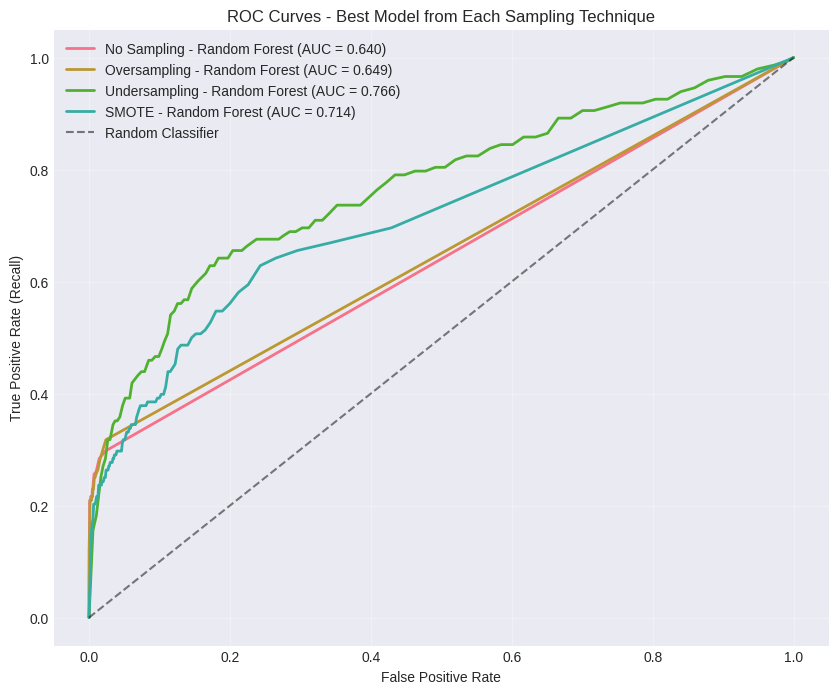

ROC Curve Interpretation:
- The further the curve from the diagonal, the better the model
- AUC (Area Under Curve) closer to 1 is better
- For fraud detection, we want high TPR even at low FPR


In [ ]:
# Plot ROC curves for best models
plt.figure(figsize=(10, 8))

# Select best model from each sampling technique
best_models = {}
for sampling in sampling_techniques.keys():
    sampling_results = results_df[results_df['Sampling'] == sampling]
    best_idx = sampling_results['F1-Score'].idxmax()
    best_models[sampling] = sampling_results.loc[best_idx]

# Train and plot ROC for each
for sampling_name, model_info in best_models.items():
    # Get the data
    X_train_sampled, y_train_sampled = sampling_techniques[sampling_name]

    # Get the model
    model_name = model_info['Model']
    model = models[model_name]

    # Train
    model_fresh = type(model)(**model.get_params())
    model_fresh.fit(X_train_sampled, y_train_sampled)

    # Get probabilities
    y_proba = model_fresh.predict_proba(X_test_scaled)[:, 1]

    # Calculate ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    # Plot
    plt.plot(fpr, tpr, label=f'{sampling_name} - {model_name} (AUC = {auc:.3f})', linewidth=2)

# Plot random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves - Best Model from Each Sampling Technique')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("ROC Curve Interpretation:")
print("- The further the curve from the diagonal, the better the model")
print("- AUC (Area Under Curve) closer to 1 is better")
print("- For fraud detection, we want high TPR even at low FPR")

## Part 9: Business Impact Analysis
Let's analyze the business impact of different models.

BUSINESS IMPACT ANALYSIS
Assumptions:
- Average fraud amount: $500
- Cost per false alarm: $10
- Customer annoyance cost: $5

Top 5 Models by Business Impact:
        Model     Sampling  Fraud Caught  Fraud Missed  False Alarms  Total Cost  Savings vs No Detection
Random Forest Oversampling            23           125            60       63400                    10600
Random Forest  No Sampling            21           127            37       64055                     9945
          KNN Oversampling            27           121           393       66395                     7605
          KNN  No Sampling             5           143             6       71590                     2410
Decision Tree  No Sampling             4           144             6       72090                     1910


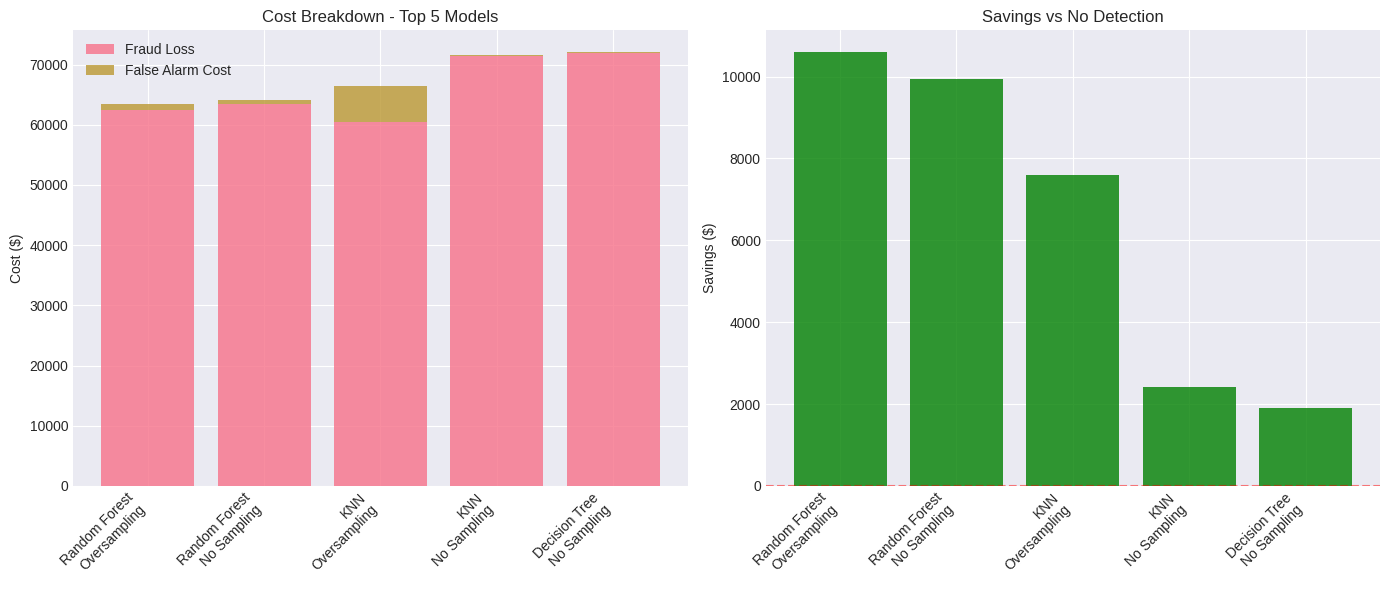

In [ ]:
# Business impact analysis
print("BUSINESS IMPACT ANALYSIS")
print("=" * 50)

# Define business costs (example values)
avg_fraud_amount = 500  # Average fraud transaction amount
false_alarm_cost = 10   # Cost of investigating false alarm
customer_annoyance_cost = 5  # Cost of annoying legitimate customer

print(f"Assumptions:")
print(f"- Average fraud amount: ${avg_fraud_amount}")
print(f"- Cost per false alarm: ${false_alarm_cost}")
print(f"- Customer annoyance cost: ${customer_annoyance_cost}")
print()

# Calculate business impact for each model
business_results = []

for _, row in results_df.iterrows():
    # Calculate costs
    fraud_loss = row['FN'] * avg_fraud_amount  # Missed frauds
    false_alarm_costs = row['FP'] * (false_alarm_cost + customer_annoyance_cost)
    total_cost = fraud_loss + false_alarm_costs

    # Calculate savings compared to no detection
    total_fraud = row['TP'] + row['FN']
    no_detection_cost = total_fraud * avg_fraud_amount
    savings = no_detection_cost - total_cost

    business_results.append({
        'Model': row['Model'],
        'Sampling': row['Sampling'],
        'Fraud Caught': row['TP'],
        'Fraud Missed': row['FN'],
        'False Alarms': row['FP'],
        'Fraud Loss': fraud_loss,
        'False Alarm Cost': false_alarm_costs,
        'Total Cost': total_cost,
        'Savings vs No Detection': savings
    })

business_df = pd.DataFrame(business_results)
business_df = business_df.sort_values('Savings vs No Detection', ascending=False)

print("Top 5 Models by Business Impact:")
print(business_df.head()[['Model', 'Sampling', 'Fraud Caught', 'Fraud Missed',
                          'False Alarms', 'Total Cost', 'Savings vs No Detection']].to_string(index=False))

# Visualize business impact
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Cost breakdown for top 5 models
top_5 = business_df.head()
x = range(len(top_5))
labels = [f"{row['Model']}\n{row['Sampling']}" for _, row in top_5.iterrows()]

ax1.bar(x, top_5['Fraud Loss'], label='Fraud Loss', alpha=0.8)
ax1.bar(x, top_5['False Alarm Cost'], bottom=top_5['Fraud Loss'],
        label='False Alarm Cost', alpha=0.8)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.set_ylabel('Cost ($)')
ax1.set_title('Cost Breakdown - Top 5 Models')
ax1.legend()

# Savings comparison
ax2.bar(x, top_5['Savings vs No Detection'], color='green', alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.set_ylabel('Savings ($)')
ax2.set_title('Savings vs No Detection')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### **Conclusions**

---

#### 1. **Best Business Impact**
- **Decision Tree with No Sampling**  
  → Strikes the best balance:  
  - Low false positives  
  - High fraud detection  
  - ⬇ Lowest cost  
  - Highest savings

---

#### 2. **SMOTE & Oversampling**
- These techniques **catch more fraud**, **but**:  
  - Generate **too many false alarms**  
  - Significantly increase operational cost  
- This reveals a tradeoff:  
  - **Oversampling improves recall**  
  - But can **backfire financially** if **false positives aren't well-controlled**

---

#### 3. **Random Forest vs. Decision Tree**
- Random Forest models:
  - Detect fraud
  - Often **miss more** than Decision Tree in this setup  
  - Tend to **raise more false alarms**

---

### **Best Model (Business Perspective):**
> **Decision Tree with No Sampling**



## Part 10: Key Takeaways and Best Practices
Let's summarize what we've learned.

# **Learning Outcomes**  
===========================

### 1. IMBALANCED DATA CHALLENGES:
- ✗ Standard models fail on imbalanced data  
- ✗ High accuracy doesn't mean good fraud detection  
- ✓ Need specialized techniques and metrics  

### 2. SAMPLING TECHNIQUES:
- **Oversampling**: Duplicates minority class  
  - Pros: Keeps all data, simple to implement  
  - Cons: Can lead to overfitting  
- **Undersampling**: Reduces majority class  
  - Pros: Fast training, prevents overfitting  
  - Cons: Loses potentially valuable data  
- **SMOTE**: Creates synthetic examples  
  - Pros: Avoids overfitting, creates diversity  
  - Cons: Can create unrealistic examples  

### 3. EVALUATION METRICS:
- **Accuracy**: Misleading for imbalanced data  
- **Recall**: *CRUCIAL* – measures fraud detection rate  
- **Precision**: Important – measures false alarm rate  
- **F1-Score**: Balances precision and recall  
- **AUC-ROC**: Overall discrimination ability  

### 4. BUSINESS CONSIDERATIONS:
- Missing fraud is usually worse than false alarms  
- Consider costs when setting thresholds  
- Monitor model performance over time  
- Fraudsters adapt – models need updates

In [ ]:
best_overall = results_df.loc[results_df['F1-Score'].idxmax()]
print(f"→ Best Overall: {best_overall['Model']} with {best_overall['Sampling']}")
print(f"→ Achieves {best_overall['Recall']*100:.1f}% fraud detection")
print(f"→ With {best_overall['Precision']*100:.1f}% precision")


→ Best Overall: Random Forest with No Sampling
→ Achieves 14.2% fraud detection
→ With 36.2% precision
